In [ ]:
#CA-SPCFAR

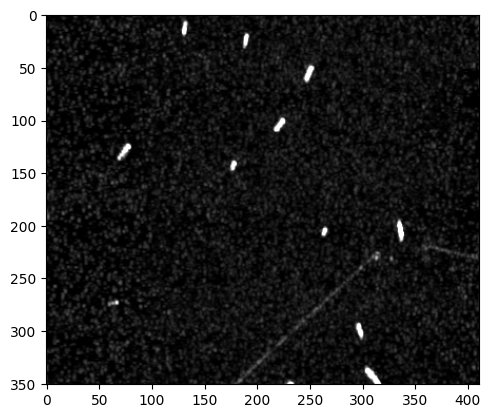

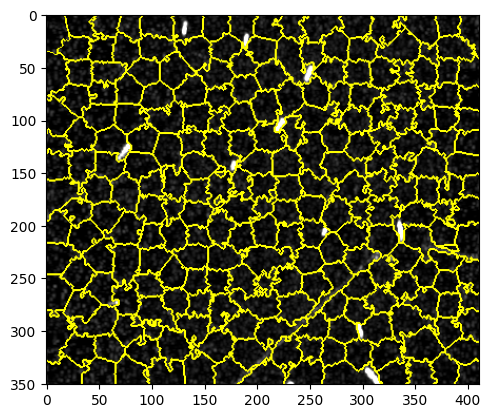

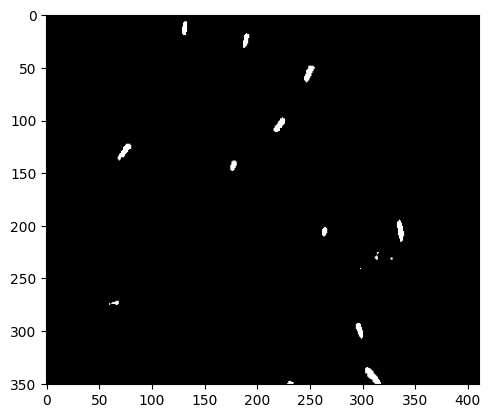

Detected targets: 770
Runtime: 4.407644987106323 seconds


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.segmentation import slic, mark_boundaries
from skimage.filters import threshold_mean
from tkinter import filedialog, Tk
import cv2
import time

# Initialize hyperparameters
back_size = 30
guard_size = 10
PFA = 0.001
detections = 0
SLIC_k = 300
SLIC_m = 10


# Read Image
root = Tk()
root.withdraw()
filename = filedialog.askopenfilename()
img = io.imread(filename, as_gray=True)
img = img / np.max(img)
plt.imshow(img, cmap='gray')
plt.show()
img_ext = cv2.copyMakeBorder(img, back_size, back_size, back_size, back_size, cv2.BORDER_REFLECT)
h, l = img.shape

start_time = time.time()
# SLIC Segmentation
fakeRGBimg = color.gray2rgb(img)
labels = slic(fakeRGBimg, n_segments=SLIC_k, compactness=SLIC_m, start_label=0)
boundaries = mark_boundaries(img, labels, color=(1, 1, 0)) 

# Show image
plt.imshow(boundaries)
plt.show()
# plt.imshow(labels, cmap='nipy_spectral')
# plt.show()

# Split into Superpixel Neighbourhoods
unique_labels = np.unique(labels)
superpixels = {label: img[labels == label] for label in unique_labels}
neighbours = {label: img[np.isin(labels, [n for n in unique_labels if n != label])] for label in unique_labels}

# Test throughout Image
maskimg = np.zeros_like(img)
for i in range(h):
    for j in range(l):
        cut = img[i, j]
        current_label = labels[i, j]
        guardband = superpixels[current_label]
        background = neighbours[current_label]
        
        # Cell Averaging CFAR
        mn = np.mean(background)
        N = len(background)
        a = N * (PFA ** (-1 / N) - 1)
        TH = a * mn

        # Check if CUT is target
        if cut >= TH:
            maskimg[i, j] = 1
            detections += 1
        else:
            maskimg[i, j] = 0
end_time = time.time()
plt.imshow(maskimg, cmap='gray')
plt.show()
print(f'Detected targets: {detections}')


# Calculate and print runtime
runtime = end_time - start_time
print(f"Runtime: {runtime} seconds")